# Energy Dissaggrigation

## Import

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals;

#imports
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot
pd.set_option('max_columns', 150)
import os,random, math, psutil, pickle
import gc
from scipy import stats
from scipy.stats import skew
import math
import warnings
import time

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import missingno as msno

import seaborn as sns
#sns.set(style="whitegrid")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
%matplotlib inline

#plt.rcParams['figure.figsize'] = (10, 8) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# Interactivity
from ipywidgets import interact, widgets
from sklearn.tree import export_graphviz
from IPython.display import Image

# Plotly
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly_express as px
from plotly import tools, subplots
import plotly.offline as py

# cufflinks is a wrapper on plotly
import cufflinks as cf
cf.go_offline(connected=True)

 # sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, StratifiedKFold, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.ensemble import GradientBoostingRegressor


# deep learning
import tensorflow as tf

# time series
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot

# to make this notebook's output stable across runs
np.random.seed(42)

# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Loading data

In [2]:
# loading the data from onedrive

data_dagg = pd.read_csv('C:/Users/al146/Downloads/LEEDR_data/Minute/power/processed-H01-Accounts-3-31-power-CLEAN.txt', delim_whitespace=True, names=["unixtime_GMT", "unixtime_DST",
                                                                                                                                                 "Freezer_Noofplugs", "Fridge_FridgeFreezer",
                                                                                                                                                 "Battery_Charger", "Toaster" ,"Lamp_1",
                                                                                                                                                 "Computing_Equipment_4", "Microwave", "TV_CableDecoder_Stereo",
                                                                                                                                                 "Laptop_F", "Small_Power_Down", "Dishwasher",
                                                                                                                                                 "Mains_1" ,"Lights_Down", "Hair_Styling",
                                                                                                                                                 "TV_DVD_HDDrecorder_BlueRay_Freeview_GamesConsole(removed)",
                                                                                                                                                 "Aquarium_Pump_Heater",
                                                                                                                                                 "TV_DVD_HDDrecorder_BlueRay_Freeview_GamesConsole(new)",
                                                                                                                                                 "Shower_1","Laptop_3","Sandwich_Toaster","Cooker",
                                                                                                                                                 "Tumble_Drier","Solar_PV","Laptop_2","Computing_Equipment",
                                                                                                                                                 "Washing_Machine","Kettle","Lights_Up","Lamp_Bedroom4"])

data_agg = pd.read_csv('C:/Users/al146/Downloads/LEEDR_data/Minute/power/processed-H01-Accounts-3-31-power-AUX.txt', delimiter=',', names=["unixtime_GMT", "unixtime_DST",
                                                                                                                                           "Mains_CT_measurement",
                                                                                                                                           "solar_PV_generation",
                                                                                                                                           "household_power_demand",
                                                                                                                                           "power_imported_from_grid",
                                                                                                                                           "power_exported_to_grid"])

In [3]:
from datetime import datetime
data_dagg['timestamp_GMT'] = data_dagg['unixtime_GMT'].apply(lambda x: datetime.utcfromtimestamp(x))
data_dagg['timestamp_DST'] = data_dagg['unixtime_DST'].apply(lambda x: datetime.utcfromtimestamp(x))
data_dagg = data_dagg.drop(['unixtime_DST', 'unixtime_GMT'], axis=1)

data_agg['timestamp_GMT'] = data_agg['unixtime_GMT'].apply(lambda x: datetime.utcfromtimestamp(x))
data_agg['timestamp_DST'] = data_agg['unixtime_DST'].apply(lambda x: datetime.utcfromtimestamp(x))
data_agg = data_agg.drop(['unixtime_DST', 'unixtime_GMT'], axis=1)

In [4]:
data = data_agg.join(data_dagg, how='left', rsuffix='right')
data = data.drop(['timestamp_GMTright', 'timestamp_DSTright'], axis=1)
#cols = list(data.columns.values)
cols = ['timestamp_GMT','timestamp_DST','Mains_CT_measurement','solar_PV_generation','household_power_demand','power_imported_from_grid','power_exported_to_grid',
        'Freezer_Noofplugs','Fridge_FridgeFreezer','Battery_Charger','Toaster','Lamp_1','Computing_Equipment_4','Microwave','TV_CableDecoder_Stereo','Laptop_F','Small_Power_Down',
        'Dishwasher','Mains_1','Lights_Down','Hair_Styling','TV_DVD_HDDrecorder_BlueRay_Freeview_GamesConsole(removed)','Aquarium_Pump_Heater',
        'TV_DVD_HDDrecorder_BlueRay_Freeview_GamesConsole(new)','Shower_1','Laptop_3','Sandwich_Toaster','Cooker','Tumble_Drier','Solar_PV',
        'Laptop_2','Computing_Equipment','Washing_Machine','Kettle','Lights_Up','Lamp_Bedroom4']
data = data[cols]

In [5]:
data_main = data.drop(['Battery_Charger','Lamp_1','Computing_Equipment_4','Microwave','TV_CableDecoder_Stereo','Laptop_F','Small_Power_Down',
                       'Lights_Down','Hair_Styling','TV_DVD_HDDrecorder_BlueRay_Freeview_GamesConsole(removed)','Aquarium_Pump_Heater',
                       'TV_DVD_HDDrecorder_BlueRay_Freeview_GamesConsole(new)','Shower_1','Laptop_3','Sandwich_Toaster',
                       'Laptop_2','Computing_Equipment','Lights_Up','Lamp_Bedroom4'], axis=1)

In [6]:
data_main

,timestamp_GMT,timestamp_DST,Mains_CT_measurement,solar_PV_generation,household_power_demand,power_imported_from_grid,power_exported_to_grid,Freezer_Noofplugs,Fridge_FridgeFreezer,Toaster,Dishwasher,Mains_1,Cooker,Tumble_Drier,Solar_PV,Washing_Machine,Kettle
0,2011-11-01 00:00:00,2011-11-01 00:00:00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99
1,2011-11-01 00:01:00,2011-11-01 00:01:00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99
2,2011-11-01 00:02:00,2011-11-01 00:02:00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99
3,2011-11-01 00:03:00,2011-11-01 00:03:00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99
4,2011-11-01 00:04:00,2011-11-01 00:04:00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288795,2014-04-13 23:55:00,2014-04-14 00:55:00,357.0,0.0,357.0,357.0,0.0,0.0,0.0,0,0.0,357.0,0.0,0,0.0,0.0,0
1288796,2014-04-13 23:56:00,2014-04-14 00:56:00,246.0,0.0,246.0,246.0,0.0,0.0,0.0,0,0.0,246.0,0.0,0,0.0,0.0,0
1288797,2014-04-13 23:57:00,2014-04-14 00:57:00,237.0,0.0,237.0,237.0,0.0,0.0,0.0,0,0.0,237.0,0.0,0,0.0,0.0,0
1288798,2014-04-13 23:58:00,2014-04-14 00:58:00,239.0,0.0,239.0,239.0,0.0,0.0,0.0,0,0.0,239.0,0.0,0,0.0,0.0,0


## Interactive Plots

In [ ]:
fig = go.Figure(layout=go.Layout(title=go.layout.Title(text="Energy Demand Plot")))
fig.add_trace(go.Scatter(x=data_main['timestamp_GMT'], y=data_main['household_power_demand'], mode='lines', line=go.scatter.Line(color="gray"), name='True'))
#fig.add_trace(go.Scatter(x=data_main['timestamp_GMT'], y=data_main['Freezer_Noofplugs'], mode='lines', line=go.scatter.Line(color="azure"), name='True'))
#fig.add_trace(go.Scatter(x=data_main['timestamp_GMT'], y=data_main['Fridge_FridgeFreezer'], mode='lines', line=go.scatter.Line(color="rosybrown"), name='True'))
# fig.add_trace(go.Scatter(x=validationIndex, y=y_pred_Validation,
#                     mode='lines+markers',
#                     name='Predicted'))

fig.show()

## Prediction

In [7]:
data_pred = data.drop(['timestamp_DST','Mains_CT_measurement', 'solar_PV_generation',
                       'power_imported_from_grid','power_exported_to_grid','Freezer_Noofplugs', 'Fridge_FridgeFreezer',
                       'Toaster', 'Dishwasher', 'Mains_1', 'Cooker', 'Tumble_Drier', 'Solar_PV', 'Washing_Machine', 'Kettle'], axis=1)

In [12]:
data_cnn = data_pred[(data_pred['timestamp_GMT'] > '2013-01-01')]

In [8]:
def rnn_data(df, ts, look_back=1, train_fraction=0.80, Scaler=None):
    """
    Create data for modelling
    """

    # Convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        """
        Create the dataset
        """
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    
    # Get dataset
    dataset = df[ts].values
    dataset = dataset.astype('float32')
    
    # Normalize the dataset
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))
    
    # Split into train and test sets
    train_size = int(len(dataset) * train_fraction)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
    # Reshape into X=t and Y=t+1
    look_back = look_back
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
  
    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    
    return trainX, trainY, testX, testY, dataset

In [14]:
# Initiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# window size
lag = 10

trainX, trainY, testX, testY, dataset = rnn_data(df=data_cnn, ts='household_power_demand', look_back=lag, train_fraction=0.89, Scaler=scaler)
#trainX, trainY, testX, testY, dataset = rnn_data(df=ash_df, ts='ts_log', look_back=lag, train_fraction=0.80, Scaler=scaler)

Train on 539798 samples, validate on 59978 samples
Epoch 1/200
539798/539798 [==============================] - 79s 146us/sample - loss: 0.0022 - rmse: 0.0183 - mae: 0.0183 - val_loss: 0.0021 - val_rmse: 0.0163 - val_mae: 0.0163
Epoch 2/200
539798/539798 [==============================] - 69s 127us/sample - loss: 0.0018 - rmse: 0.0153 - mae: 0.0153 - val_loss: 0.0021 - val_rmse: 0.0158 - val_mae: 0.0158
Epoch 3/200
539798/539798 [==============================] - 63s 117us/sample - loss: 0.0018 - rmse: 0.0149 - mae: 0.0149 - val_loss: 0.0020 - val_rmse: 0.0156 - val_mae: 0.0156
Epoch 4/200
539798/539798 [==============================] - 65s 120us/sample - loss: 0.0018 - rmse: 0.0147 - mae: 0.0147 - val_loss: 0.0021 - val_rmse: 0.0161 - val_mae: 0.0161
Epoch 5/200
539798/539798 [==============================] - 64s 119us/sample - loss: 0.0018 - rmse: 0.0145 - mae: 0.0145 - val_loss: 0.0020 - val_rmse: 0.0154 - val_mae: 0.0154
Epoch 6/200
539798/539798 [==============================] 

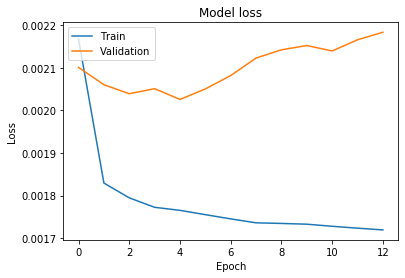

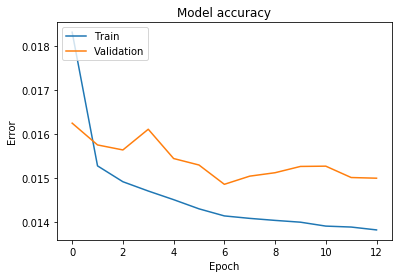

Wall time: 14min 14s


In [15]:
%%time

def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true), axis=-1)) 

epochs= 200
batch_size = 350

# reshape from [samples, time steps, features] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 1
trainX = trainX.reshape((trainX.shape[0], n_seq, lag, n_features))
testX = testX.reshape((testX.shape[0], n_seq, lag, n_features))

tf.keras.backend.clear_session()

# Create and fit the LSTM network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=128, kernel_size=2, input_shape=[None, None, 1])))
model.add(tf.keras.layers.TimeDistributed((tf.keras.layers.MaxPooling1D(pool_size=2))))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=128, kernel_size=2)))
model.add(tf.keras.layers.TimeDistributed((tf.keras.layers.MaxPooling1D(pool_size=2))))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(65, return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, kernel_initializer='glorot_normal', activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(25, kernel_initializer='glorot_normal', activation='relu')))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10, kernel_initializer='glorot_normal', activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, kernel_initializer='glorot_normal', activation='relu')))

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss='mse', optimizer=optimizer, metrics=[rmse, 'mae'])
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size, verbose = 1, validation_split=0.1, callbacks = [early_stopping_monitor], shuffle=False, workers=0)

#print('Loss (MSE):', history.history['loss'][-1], '\nVal_loss (MSE):', history.history['val_loss'][-1])
# score_rmse_train = model.evaluate(trainX, trainY, verbose = 0)
# score_rmse_test = model.evaluate(testX, testY, verbose = 0)
# print('Train Score (MSE, RMSE, MAE):', score_rmse_train)
# print('Test Score (MSE, RMSE, MAE):', score_rmse_test)

model.summary()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model accuracy')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

74121/74121 [==============================] - 3s 37us/sample
TRAINING SET
MAE:                 225.55316
MSE:                 487871.72
RMSE:                698.4781447905152
TEST SET
MAE:                 235.86588
MSE:                 496834.22
RMSE:                704.8646811622781


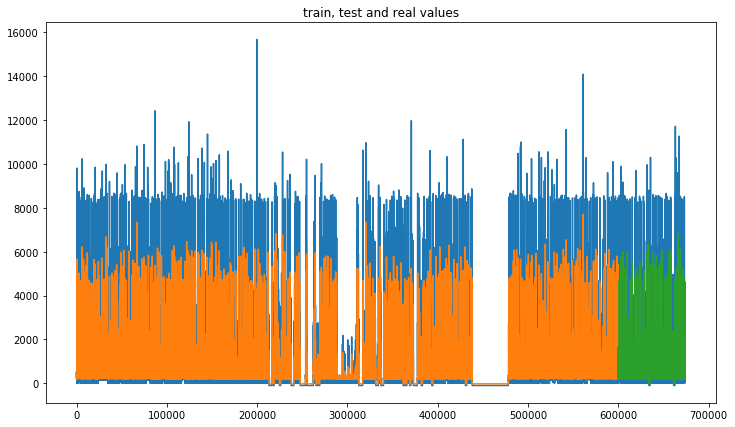

In [16]:
# Make predictions
trainPredict = model.predict(trainX, batch_size=batch_size, verbose=1)
testPredict = model.predict(testX, batch_size=batch_size, verbose=1)
look_back = lag
    
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape((trainPredict.shape[0],1)))
trainY = scaler.inverse_transform(trainY.reshape((trainY.shape[0],1)))
testPredict = scaler.inverse_transform(testPredict.reshape((testPredict.shape[0],1)))
testY = scaler.inverse_transform(testY.reshape((testY.shape[0],1)))

mae = metrics.mean_absolute_error(trainY,trainPredict)
mse = metrics.mean_squared_error(trainY,trainPredict)
print ("TRAINING SET")
print ("============")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))


mae = metrics.mean_absolute_error(testY,testPredict)
mse = metrics.mean_squared_error(testY,testPredict)
print ("TEST SET")
print ("========")
print ("MAE:                ", mae)
print ("MSE:                ", mse)
print ("RMSE:               ", math.sqrt(mse))

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+lag, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lag*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
plt.figure(figsize=(12,7))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
plt.title('train, test and real values')
plt.show()

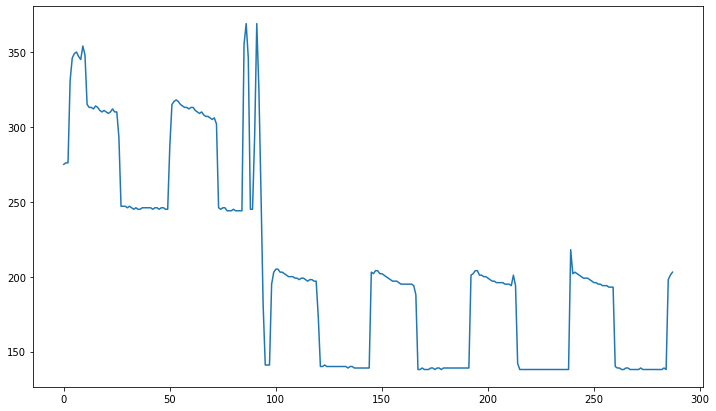

In [17]:
plt.figure(figsize=(12,7))
plt.plot(scaler.inverse_transform(dataset[10000:10288]))
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot[10000:10288])
#plt.vlines(x=9687, ymin=0, ymax=8, colors='k', linestyles='dashed')
#plt.title('train, test and real values')
plt.savefig('test_day.png', dpi=300)

plt.show()

In [18]:
actual_values = scaler.inverse_transform(dataset).flatten('F')
actual_values.reshape(-1, 1)
trainPredictPlot = trainPredictPlot.flatten('F')
trainPredictPlot.reshape(-1, 1)
testPredictPlot = testPredictPlot.flatten('F')
testPredictPlot.reshape(-1, 1)

array([[      nan],
       [      nan],
       [      nan],
       ...,
       [268.6318 ],
       [277.00388],
       [      nan]], dtype=float32)

In [19]:
error_distro = pd.DataFrame(np.vstack((actual_values, testPredictPlot)))
error_distro = error_distro.transpose() 
error_distro.columns=['actual_value','testPredict']

error_distro.drop(error_distro.index[0:9687], inplace=True)
error_distro.drop(error_distro.index[len(error_distro)-1], inplace=True)
error_distro['residuals'] = error_distro['actual_value'] - error_distro['testPredict']

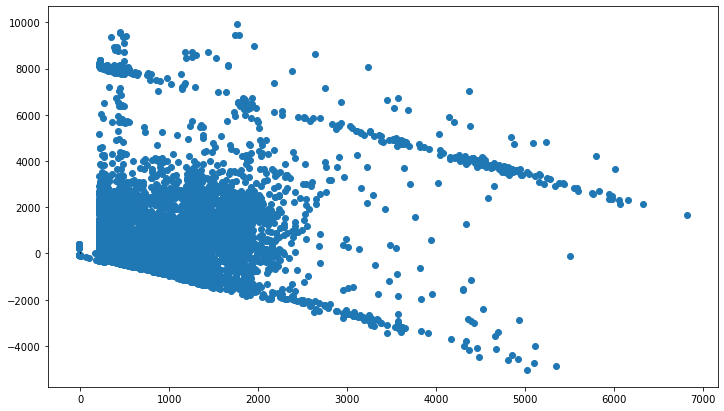

In [20]:
plt.figure(figsize=(12,7))
plt.scatter(error_distro['testPredict'], error_distro['residuals'])
plt.hlines(xmin=0, y=0, xmax=3, colors='k', linestyles='dashed')
plt.show()

In [21]:
# # model values
# model_fitted_y = error_distro['testPredict']
# # model residuals
# model_residuals = error_distro['residuals']
# # normalized residuals
# model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# # absolute squared normalized residuals
# model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# # absolute residuals
# model_abs_resid = np.abs(model_residuals)
# # leverage, from statsmodels internals
# model_leverage = model_fit.get_influence().hat_matrix_diag
# # cook's distance, from statsmodels internals
# model_cooks = model_fit.get_influence().cooks_distance[0]

# plot_lm_1 = plt.figure()
# plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
#                           lowess=True,
#                           scatter_kws={'alpha': 0.5},
#                           line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# plot_lm_1.axes[0].set_title('Residuals vs Fitted')
# plot_lm_1.axes[0].set_xlabel('Fitted values')
# plot_lm_1.axes[0].set_ylabel('Residuals');

count    74121.000000
mean        98.982330
std        697.884827
min      -5024.791992
25%        -76.789108
50%        -27.328522
75%         31.844910
max       9944.345703
Name: residuals, dtype: float64

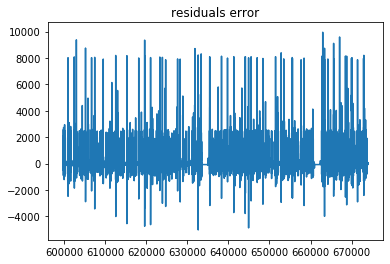

In [22]:
ax = sns.lineplot(data=error_distro['residuals'])
ax.set_title('residuals error')
error_distro['residuals'].describe()

Text(0.5, 1.0, 'Histogram Plot of Residual Errors')

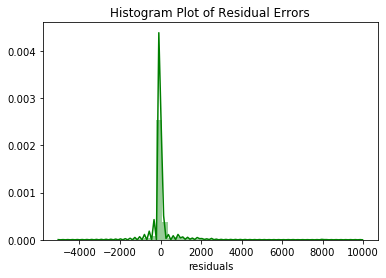

In [24]:
#residuals['CNN-LSTM'] = error_distro['residuals']

ax = sns.distplot(error_distro['residuals'], kde=True, color="g")
ax.set_title('Histogram Plot of Residual Errors')

## Dissag